In [1]:
import sys
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# adding Folder_2 to the system path
sys.path.insert(0, '../Python')

from helper_add_ep_wp import add_ep_variables
from helper_add_hudl_mutations import make_hudl_mutations, prepare_wp_data
from helper_add_model_mutations import make_wp_model_mutations

In [2]:
df = pl.read_csv("../data_raw.csv",separator=";",infer_schema_length=0)
df1 = make_hudl_mutations(df)
df2 = prepare_wp_data(df1)

In [3]:
# Spaltenauswahl
selected_columns = [
    "label",
    "receive_2h_ko",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "Diff_Time_Ratio",
    "score_differential",
    "down",
    "yards_to_go",
    # "yards_to_go_simple",
    "yardline_50"
    # "yardline_50_simple"
    ]

features = [
    "receive_2h_ko",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "Diff_Time_Ratio",
    "score_differential",
    "down",
    "yards_to_go",
    # "yards_to_go_simple",
    "yardline_50"
    # "yardline_50_simple"
    ]

In [4]:
model_data = df2.filter(pl.col("game_id") != 35)

model_data = make_wp_model_mutations(model_data, selected_columns)

In [5]:
for x in model_data.columns: # df.columns returns a list of columns
  print("{} : {}".format(x, model_data[x].null_count()))

label : 0
receive_2h_ko : 0
half_seconds_remaining : 0
game_seconds_remaining : 0
Diff_Time_Ratio : 0
score_differential : 0
down : 43
yards_to_go : 43
yardline_50 : 0


In [6]:
model_data = model_data.drop_nulls()

X= model_data.select(features)
y = model_data.select("label")
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state = 42)

In [7]:
model = xgb.XGBRegressor(
    booster = "gbtree",
    objective = "binary:logistic",
    eval_metric = "logloss",
    eta = 0.2,
    gamma = 0,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth = 4,
    min_child_weight = 1
)

model.fit(train_X.drop("label").to_numpy(), train_y.select("label").to_numpy())
model.get_booster().feature_names = features

<Figure size 640x480 with 0 Axes>

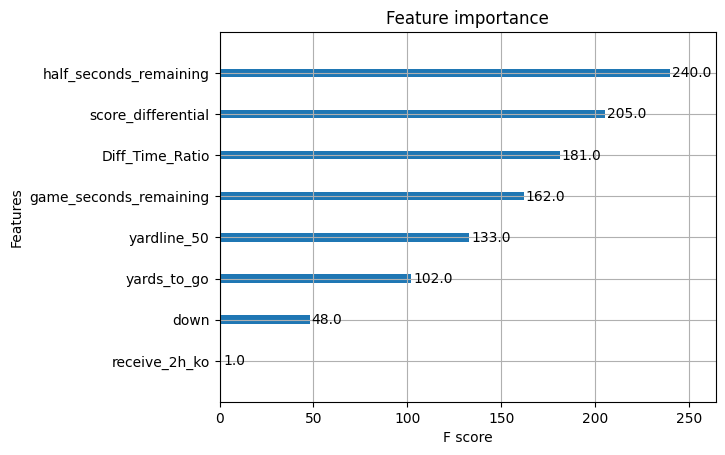

In [8]:
fig=plt.gcf()
xgb.plot_importance(model)
# plt.title("Feature Importance for "+asset_name)
plt.show()

In [9]:
space={
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    # "max_depth": 3,
    'gamma': hp.uniform ('gamma', 0,9),
    # "gamma": 0,
    'reg_alpha': hp.uniform('reg_alpha', 0,0.05),
    # 'reg_alpha': 140.0,
    'reg_lambda': hp.uniform('reg_lambda', 0,1),
    # 'reg_lambda': 0.2,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1),
    # "colsample_bytree": 0.8,
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    # "min_child_weight": 3,
    'n_estimators': hp.quniform('n_estimators', 1, 1000, 50),
    "eta": hp.uniform("eta", 0.01, 0.1),
    'seed': 0
    }

In [12]:
def model_objective(space):
    clf=xgb.XGBClassifier(
        n_estimators = int(space['n_estimators']), 
        eta = space["eta"],
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( train_X, train_y), ( test_X, test_y)]
    
    clf.fit(train_X, train_y,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test_X)
    accuracy = accuracy_score(test_y, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [13]:
import warnings

# Unterdrücken von UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

trials = Trials()

best_hyperparams = fmin(fn = model_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# Zurücksetzen der Warnungseinstellungen, wenn nötig
warnings.resetwarnings()

SCORE:                                                 
0.8410041841004184                                     
SCORE:                                                 
0.8228730822873083                                                                
SCORE:                                                                            
0.8493723849372385                                                                
SCORE:                                                                            
0.49511854951185497                                                               
SCORE:                                                                            
0.8451882845188284                                                                
SCORE:                                                                            
0.8437935843793585                                                                
SCORE:                                                                            
0.

In [14]:
best_hyperparams

{'colsample_bytree': 0.5512086071187006,
 'eta': 0.04278928320643336,
 'gamma': 4.22234896275214,
 'max_depth': 8.0,
 'min_child_weight': 6.0,
 'n_estimators': 150.0,
 'reg_alpha': 0.04837614452403155,
 'reg_lambda': 0.8626838069725705}

In [16]:
model_tune = xgb.XGBRegressor(
    booster = "gbtree",
    objective = "binary:logistic",
    eval_metric = "logloss",
    n_estimators = int(best_hyperparams["n_estimators"]),
    eta = best_hyperparams["eta"],
    gamma = best_hyperparams["gamma"],
    colsample_bytree = best_hyperparams["colsample_bytree"],
    max_depth = int(best_hyperparams["max_depth"]),
    min_child_weight = int(best_hyperparams["min_child_weight"]),
    reg_alpha = best_hyperparams["reg_alpha"],
    reg_lambda = best_hyperparams["reg_lambda"]
)

model_tune.fit(model_data.select(features).to_numpy(), model_data.select("label").to_numpy())
model_tune.get_booster().feature_names = features

<Figure size 640x480 with 0 Axes>

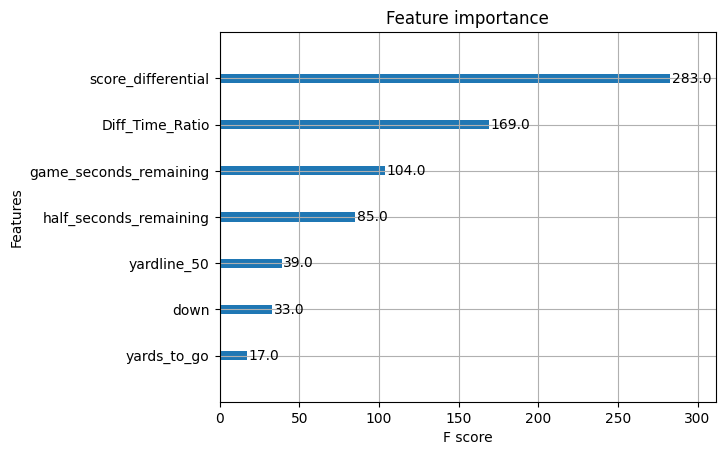

In [20]:
fig=plt.gcf()
xgb.plot_importance(model_tune)
# plt.title("Feature Importance for "+asset_name)
plt.show()

In [18]:
import pickle
file_name = "wp_model.pkl"
# save
pickle.dump(model_tune, open(file_name, "wb"))

C:\Users\Templer\AppData\Local\Temp\ipykernel_40720\584864870.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='wp_model.pkl'>
  pickle.dump(model_tune, open(file_name, "wb"))
